## imports

In [3]:
from lmfit.models import GaussianModel, PowerLawModel, LognormalModel
from matplotlib.pyplot import *
from jupyterthemes import jtplot
import matplotlib.ticker as ticker
from probfit import UnbinnedLH, gaussian, Extended, BinnedLH, describe, BinnedChi2
from openpyxl import load_workbook
from iminuit import Minuit
import matplotlib.pyplot as plt
import scipy as sp
import glob
from matplotlib import mlab
import matplotlib
import seaborn as sns
import math
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from scipy import asarray as ar, exp
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from itkwidgets import view
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import probfit
import iminuit
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
import sys
from PIL import Image
from matplotlib.ticker import ScalarFormatter
import datetime as DT
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import numpy as np
from scipy.optimize import curve_fit
import pylab

from pylab import *
from scipy.linalg import *


# Display all cell outputs
InteractiveShell.ast_node_interactivity = 'all'
%config IPCompleter.greedy = True
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

# Visualizations
init_notebook_mode(connected=True)
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
matplotlib.use('nbagg')

## functions

In [4]:
def file_reading (file):
    date, snr = [],[]
    data = ([x.split() for x in open(file).readlines()])
    for i in range(len(data)):
        date.append(str(data[i][0]))
        snr.append(float(data[i][1]))
    return date, snr    

def integral_hist (snr, step,name_source):
    x = []
    for i in range(round(min(snr)), round(max(snr)), step):
        x.append(i)
        
    #x = np.linspace(round(min(snr)), round(max(snr)), step)
    if name_source == 'J1502+28':
        x = []
        for i in range(7, round(max(snr)), step):
            x.append(i)
            
    if name_source == 'J0640+07':
        x = []
        for i in range(6, round(max(snr)), step):
            x.append(i)
        
    
    y = (np.histogram(snr, x)[0])
    print(y)
    x_hist = x[:-1]
    y2 = list(y)
    y_int = []
    for i in range(len(y)):
        y_int.append(sum(y2))
        _ = y2.pop(0)
    int_hist = y_int
    return int_hist, x_hist 

def fitting (model, int_hist, x_hist, TREASHOLD):
    y = int_hist
    x = x_hist
  
    def y_0 (x,a,b):
        return [0*x for x in x]
    def linear (a,b):
        return [a*x+b for x in x]
    def lognorm(x, q, w, e):
        return [(q / x) * np.exp(-(((math.log(x) - w)**2) / (2 * e**2))) for x in x]
    def power(x, a, b):
        return a*np.power(x, b) 
    def power_1005_1(x, a, b):
        return [3.186*np.power(x, -0.724) for x in x]
    
    def power_1005_2(x, a, b):
        return [6.206*np.power(x, -2.378) for x in x]

    if model == 'y_0':
        count, TREASHOLD = 1,1
        gmodel = Model(y_0)
        result = gmodel.fit(y, x=x, a=1, b=1)
        param = []
        for name, par in result.params.items():
            param.append(round(par.value,2))
            
        print('CHI-SQUARE for ALL points')
        print(result.fit_report())
        
        return result, param, count, TREASHOLD

    if model == 'linear':
        count, TREASHOLD = 1,1
        gmodel = Model(linear)
        result = gmodel.fit(y, x=x, a=0.5, b=0.5)
        param = []
        for name, par in result.params.items():
            param.append(round(par.value,2))
            
        #print('aic = ', round(result.aic,2))
        #popt, pcov = curve_fit(linear, x, y)
        return result, param, count, TREASHOLD#, popt, pcov
          
    if model == 'power-power':
        gmodel1 = Model(power)
        gmodel2 = Model(power)
        count = 0
        i = 0
        
        if 0 in y:
        
            while y[i] > 1:
                count +=1
                i+=1
        else:
            count = len(y)
           
        print(len(y[0:TREASHOLD]), len(y[TREASHOLD:count]), count)
        result1 = gmodel1.fit(y[0:TREASHOLD], x=x[0:TREASHOLD], a=1, b=1)
        print(result1.fit_report())
        
        result2 = gmodel2.fit(y[TREASHOLD:count], x=x[TREASHOLD:count], a=1, b=1)
        print(result2.fit_report())


        param1 = []
        for name, par in result1.params.items():
            param1.append(round(par.value,2))

        param2 = []
        for name, par in result2.params.items():
            param2.append(round(par.value,2))
            
        return result1, result2, param1, param2, count, TREASHOLD

    if model == 'power':
        count = 0
        i = 0
        if 0 in y:
            while y[i] > 1:
                count +=1
                i+=1
        else:
            count = len(y)

        
        TREASHOLD = count
        
        ydata = y[:count]
        xdata = x[:count]
        xData = xdata
        yData = ydata
        lx = np.log(xData)
        ly = np.log(yData)

        def f(x, N, a):
            return N * x ** (-a)

        def f_log(x, lN, a):
            return a * x + lN

        popt, pcov = curve_fit(f, xData, yData)
        popt_log, pcov_log = curve_fit(f_log, lx, ly)
        print('===========')
        print('параметры для синего (линейн)')
        
        #print(pcov_log)
        
        print(np.exp(popt_log[0]), -popt_log[1])
        
        def custom_pow (x, a,b):
            return [np.exp(popt_log[0])*(x**(popt_log[1])) for x in x]
            
         
        gmodel = Model(custom_pow)
        result1 = gmodel.fit(y[:count], x=x[:count], a=popt_log[0],b=-popt_log[1])

        print('===========')
        print('отчет по степенному (синему)')
        print(result1.fit_report(min_correl=0.25))
        #for name, par in result1.params.items():
        #     print("  %s: value=%f +/- %f " % (name, par.value, par.stderr))
        
        print('+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!')
        print(result1.params.items())
        
        a_x = x[:count]
        a_y = y[:count]
        
        #a2 = [np.exp(popt_log[0])*(x**(-popt_log[1]))for x in xData]
        #a2 = custom_pow (a_x, popt_log[0], popt_log[1])
        a2 = [np.exp(popt_log[0])*x**popt_log[1] for x in x_hist[:count]]
        print(a2)
        
        for_chi_1 = [int_hist[i] - a2[i] for i in range(len(a2))]
        #for_chi_1 = a_x -  a2
        print(for_chi_1)
        
        print('STD для синего: ', np.std(for_chi_1))
        

        gmodel2 = Model(power)
        result2 = gmodel2.fit(y[:count], x=x[:count], a=1, b=1)
        print('отчет по степенному (красному)')
        print(result2.fit_report(min_correl=0.25))

        param1 = []
        for name, par in result2.params.items():
            param1.append(round(par.value,2))
            
        a = int_hist[:count]
        b2 = [param1[0]*np.power(x, -param1[1]) for x in x_hist[:count]]
        #for_chi_2 = [a[i] - b2[i] for i in range(len(a))]
        for_chi_2 = a - result2.best_fit 
        
        print('STD для красного: ', np.std(for_chi_2))
        
        return result1, result2, count, TREASHOLD, popt_log, param1
        
    if model == 'lognorm':
        count = 0
        i = 0
        if 0 in y:
        
            while y[i] > 1:
                count +=1
                i+=1
        else:
            count = len(y)

        TREASHOLD = count
        gmodel = Model(lognorm)
        result = gmodel.fit(y[:TREASHOLD], x=x[:TREASHOLD], q=1, w=1, e=1)
        param = []
        for name, par in result.params.items():
            param.append(round(par.value,2))
            
        print('aic = ', round(result.aic,2))
        print(result.fit_report())

        
        return result, param, count, TREASHOLD
    
    if model == 'lognorm-power':
        count,i = 0,0
        if 0 in y:
        
            while y[i] > 1:
                count +=1
                i+=1
        else:
            count = len(y)
            
        #y = [math.log(y[i]) for i in range(len(y))]
        
        gmodel = Model(lognorm)
        result1 = gmodel.fit(y[:TREASHOLD], x=x[:TREASHOLD], q=1, w=1, e=1)
        param = []
        for name, par in result1.params.items():
            param.append(round(par.value,2))
            
        print('===========')
        print('отчет по логнормальному')
            
        print(result1.fit_report(min_correl=0.25))

        ydata = y[TREASHOLD:count]
        print(ydata)
        xdata = x[TREASHOLD:count]

        # generate some data with noise
        xData = xdata
        yData = ydata

        # get logarithmic data
        lx = np.log(xData)
        ly = np.log(yData)

        def f(x, N, a):
            return N * x ** (-a)

        def f_log(x, lN, a):
            return a * x + lN

        # optimize using the appropriate bounds
        popt, pcov = curve_fit(f, xData, yData)
        popt_log, pcov_log = curve_fit(f_log, lx, ly)
        print('===========')
        print('параметры для синего')
        
        print(np.exp(popt_log[0]), -popt_log[1])
        print(pcov_log)
        print('===========')
        

        xnew = np.linspace(min(xdata), max(xdata), 10)

        
        def custom_pow (x, a,b):
            return np.exp(popt_log[0])*x**popt_log[1] 
            
         
        gmodel = Model(custom_pow)
        result2 = gmodel.fit(yData, x=xData, a=popt_log[0],b=popt_log[1])
        
        
        print('===========')
        print('отчет по степенному (синему)')
        
        print(result2.fit_report(min_correl=0.25))
        
        
        gmodel2 = Model(power)
        result2 = gmodel2.fit(y[TREASHOLD:count], x=x[TREASHOLD:count], a=1, b=1)
        print('отчет по степенному (красному)')
        print(result2.fit_report(min_correl=0.25))
        
        
        a = int_hist[TREASHOLD:count]
        a2 = [np.exp(popt_log[0])*x**popt_log[1] for x in x_hist[TREASHOLD:count]]
        for_chi_1 = [a[i] - a2[i] for i in range(len(a))]
        print('STD для синего: ', np.std(for_chi_1))
        
        param1 = []
        for name, par in result2.params.items():
            param1.append(round(par.value,2))
            
        b2 = [param1[0]*np.power(x, param1[1]) for x in x_hist[TREASHOLD:count]]
        for_chi_2 = [a[i] - b2[i] for i in range(len(a))]
        print('STD для красного: ', np.std(for_chi_2))
        
        x_ext1 = [i for i in x_hist[1:TREASHOLD+1]]
        #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #print(count)
       
        #ext1 =  [param1[0]*np.power(x, param1[1]) for x in x_ext1]
        
        
        
        ext1 = [np.exp(popt_log[0])*x**popt_log[1] for x in x_ext1]
        x_ext2 = [i for i in x_hist[1:count]]
        
        
        ext2 = [(param[0] / x) * np.exp(-(((math.log(x) - param[1])**2) / (2 * param[2]**2)))  for x in x_ext2]
        
        
        
        
        #ext = [(param1[0] / x) * np.exp(-(((math.log(x) - param1[1])**2) / (2 * param1[2]**2))) for x in x_ext] 

        return result1, result2, count, TREASHOLD, popt_log, x_ext1, x_ext2, ext1, ext2
    
    if model == 'power_1005':
        
        gmodel1 = Model(power_1005_1)
        gmodel2 = Model(power_1005_2)
        count = 0
        i = 0
        if 0 in y:
        
            while y[i] > 1:
                count +=1
                i+=1
        else:
            count = len(y)
           
        print('cheeer')
        result1 = gmodel1.fit(y[0:TREASHOLD], x=x[0:TREASHOLD], a=1, b=1)
        result2 = gmodel2.fit(y[TREASHOLD:count], x=x[TREASHOLD:count], a=1, b=1)
        print(result1.fit_report())
        print(result2.fit_report())
        
        param1 = []
        for name, par in result1.params.items():
            param1.append(round(par.value,2))

        param2 = []
        for name, par in result2.params.items():
            param2.append(round(par.value,2))
            
        return result1, result2, param1, param2, count, TREASHOLD
    
def distribution (model, name_source, TREASHOLD):
    def power(x, a, b):
        return [a*np.power(x, -b) for x in x]  
    def f(x, N, a):
            return N * x ** (-a)
    
    #%matplotlib inline
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title(name_source, size = 25)
    ax.loglog()
    plt.minorticks_off()
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20)
    
    ax.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'minor',    #  Применяем параметры к вспомогательным делениям
               direction = 'out',    #  Рисуем деления внутри и снаружи графика
               length = 3,    #  Длинна делений
               width = 1,     #  Ширина делений
               color = 'black',    #  Цвет делений
               pad = 100,    #  Расстояние между черточкой и ее подписью
               #labelsize = 15,    #  Размер подписи
               #labelcolor = 'r',    #  Цвет подписи
               bottom = True,    #  Рисуем метки снизу
               #top = True,    #   сверху
               left = True)    #  слева
               #right = True) 
        
    ax.minorticks_on()
    
    #-4.70205924 +/- 0.06314822
    
    #5.03478155 +/- 0.47924032 
    #-3.08712886 +/- 0.08087832 
    #-5.21818324 +/- 0.16494360 (3.16%) (init = 1)
    #3.71915053 +/- 0.08796152 (2.37%) (init = 1)
    #-4.20733575 +/- 0.22850775 (5.43%) (init = 1)
    #5.88142672 +/- 0.10323653 
    
   # ax.text(int(max(x_hist)*0.6), int(max(int_hist)*0.05), 'n = -5.89 ± 0.18',
   #     fontsize = 13)
    #-4.50184588 +/- 0.03037483 
    #-5.89389510 +/- 0.18044693 
    #ax.text(int(max(x_hist)*0.4), int(max(int_hist)*0.01), 'n =  -3.84 ± 0.06',
    #    fontsize = 13)
    
    
    plt.legend(prop={'size': 6})

    if name_source == 'J0139+33' or name_source == 'J0640+07' or name_source == 'J1336+33' or name_source == 'J1848+15':
        plt.ylabel('Number of pulses', size = 23)    
    if name_source == 'J2051+12' or name_source == 'J2209+22' or name_source == 'J2105+19' or name_source == 'J1848+15':
        plt.xlabel('S/N', size = 23)

    if model == 'power-power':
        
        result1, result2, param1, param2, count, TREASHOLD = fitting (model, int_hist, x_hist, TREASHOLD)
        plt.plot(x_hist[0:TREASHOLD], int_hist[0:TREASHOLD], 'o', ms = 7 , color = 'k',alpha = 0.8)
        plt.plot(x_hist[TREASHOLD-1:], int_hist[TREASHOLD-1:], 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[0:TREASHOLD], result1.best_fit, 'r-', label='power2', color = 'green', alpha = 0.8)
        plt.plot(x_hist[TREASHOLD:count], result2.best_fit, 'r-', label='power1', color = 'darkblue', alpha = 0.8)
        #plt.savefig('/home/elinxt/RRAT/Distributions/' + name_source + ' 2-power.png')
        plt.savefig('/home/oem/work/rrat/distributions/' + name_source + ' 2-power.png')
        
        plt.legend(loc='best');
        plt.show();
        
        a = int_hist[0:TREASHOLD]
        b = int_hist[TREASHOLD:count]      
       
        a2 = [param1[0]*np.power(x, param1[1]) for x in x_hist[0:TREASHOLD]]
        b2 = [param2[0]*np.power(x, param2[1]) for x in x_hist[TREASHOLD:count]]
        for_chi_1 = [a2[i] - a[i] for i in range(len(result1.best_fit))]
        for_chi_2 = [b2[i] - b[i] for i in range(len(result2.best_fit))]
        for_chi = []

        for i in range(len(for_chi_1)):
            for_chi.append(for_chi_1[i])
            
        for i in range(len(for_chi_2)):
            for_chi.append(for_chi_2[i])
            
        print('STD: ', np.std(for_chi))
         
        x_for_chi = [i for i in range(len(for_chi))]
        model = 'y_0'
        result, param, count, TREASHOLD = fitting (model, for_chi, x_for_chi, TREASHOLD)      
    if model == 'power':
        
        result1, result2, count, TREASHOLD, popt_log, param1 = fitting (model, int_hist, x_hist, TREASHOLD)
        print('==============================!!!!!!!!!!!!+===============================')
        print(param1)
        plt.plot(x_hist, int_hist, 'o', ms = 7, color = 'k',alpha = 0.8)
       # plt.plot(x_hist[:TREASHOLD], power(x_hist[:TREASHOLD], *popt))
        #plt.plot(x_hist[:TREASHOLD], f(x_hist[:TREASHOLD], np.exp(popt_log[0]), -popt_log[1]), 'b', label = 'power')
        plt.plot(x_hist[:TREASHOLD], result2.best_fit, 'r-', label='power', color = 'blue', alpha = 0.8)
        #plt.plot(x_hist[:TREASHOLD], result.best_fit, 'r-', label='power', color = 'green', alpha = 0.8)
        plt.legend(loc='best',prop={'size': 13})
        
        plt.savefig('/home/oem/work/rrat/distributions/' + name_source + ' power.png')
        
        a = int_hist[:TREASHOLD]
        a2 = [param1[0]*np.power(x, -param1[1]) for x in x_hist[:TREASHOLD]]
        for_chi = [a2[i] - a[i] for i in range(len(result2.best_fit))]
        print('STD: ', np.std(for_chi))

        plt.show();
    if model == 'lognorm':
        result, param, count, TREASHOLD = fitting (model, int_hist, x_hist, TREASHOLD)

        a = int_hist
        a2 = [(param[0] / x) * np.exp(-(((math.log(x) - param[1])**2) / (2 * param[2]**2))) for x in x_hist[:TREASHOLD]] 
        
        for_chi = [a2[i] - a[i] for i in range(len(result.best_fit))]
        print('STD: ', np.std(for_chi))
        plt.plot(x_hist, int_hist, 'o', ms = 7, color = 'k',alpha = 0.8)
        #plt.plot(x, linear(x, *popt))
        plt.plot(x_hist[:TREASHOLD], result.best_fit, 'r-', label='lognorm', color = 'green', alpha = 0.8)
        #plt.legend(loc='best')
        plt.savefig('/home/oem/work/rrat/distributions/' + name_source + ' logmorm.png')
    if model == 'lognorm-power':
        
        
        result1, result2, count, TREASHOLD, popt_log, x_ext1, x_ext2, ext1, ext2 = fitting (model, int_hist, x_hist, TREASHOLD)
        plt.plot(x_ext1, ext1, '--', color = 'b', alpha = 0.8)
        plt.plot(x_ext2, ext2, '--', color = 'g', alpha = 0.8)
        
        plt.plot(x_hist[0:TREASHOLD], int_hist[0:TREASHOLD], 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[TREASHOLD-1:], int_hist[TREASHOLD-1:], 'o', ms = 7, color = 'k',alpha = 0.8)
        
        plt.plot(x_hist[0:TREASHOLD], result1.best_fit, 'r-', label='lognorm', color = 'green')#, alpha = 0.8)
        plt.plot(x_hist[TREASHOLD:count], f(x_hist[TREASHOLD:count], np.exp(popt_log[0]), -popt_log[1]), 'b', label='power')
        #plt.plot(x_hist[TREASHOLD:count], result2.best_fit, 'r-', label='power', color = 'blue', alpha = 0.8)

        plt.savefig('/home/oem/work/rrat/distributions/' + name_source + ' logmorm+power.png')
        plt.legend(loc='best');
        #pylab.legend (loc='upper right')
        plt.show();   
        
        a = int_hist[0:TREASHOLD]
        b = int_hist[TREASHOLD:count] 
        
        param1 = []
        for name, par in result1.params.items():
            param1.append(round(par.value,2))
            
        param2 = []
        for name, par in result2.params.items():
            param2.append(round(par.value,2))

        
        #a2 = [param1[0]*np.power(x, param1[1]) for x in x_hist[0:TREASHOLD]]
        #a2 = [np.exp(popt_log[0])*x**popt_log[1] for x in x_hist[TREASHOLD:count]]
        a2 =  [(param1[0] / x) * np.exp(-(((math.log(x) - param1[1])**2) / (2 * param1[2]**2))) for x in x_hist[0:TREASHOLD]]
        
        b2 = [param2[0]*np.power(x, param2[1]) for x in x_hist[TREASHOLD:count]]
        for_chi_1 = [a2[i] - a[i] for i in range(len(result1.best_fit))]
        for_chi_2 = [b2[i] - b[i] for i in range(len(result2.best_fit))]
        for_chi = []

        for i in range(len(for_chi_1)):
            for_chi.append(for_chi_1[i])
            
        for i in range(len(for_chi_2)):
            for_chi.append(for_chi_2[i])
            
        print('STD: ', np.std(for_chi))
         
        x_for_chi = [i for i in range(len(for_chi))]
        model = 'y_0'
        result, param, count, TREASHOLD = fitting (model, for_chi, x_for_chi, TREASHOLD)    
      
def snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number):
    snr_number, number, my_list, day_number = [], [], [], []
    s,n,d = 0,0,0


    start_date = DT.datetime(2014, 8, 1)
    end_date = DT.datetime(2019, 12, 31)

    my_list = pd.date_range(
        min(start_date, end_date),
        max(start_date, end_date)
    ).strftime('%d.%m.%Y').tolist()
    
    day_number_all = []
    for i in range(len(my_list)):
        if my_list[i] not in date:
            day_number_all.append(0)
    for i in range(len(date)-1):
        try:
            if date[i] == date[i+1]:
                d+=1
            else:
                d+=1
                day_number.append(d)
                d = 0
            #print(i, len (day_number))
        except Excrption as e:
            #print(e)
            continue
    for i in range(len(date)):
        try:
            if date[i][-7:] == date[i+1][-7:]:
                s += snr[i]
                n += 1
            else:
                if date[i][-7:] ==  date[i-1][-7:]:
                    s += snr[i]
                    n += 1
                    snr_number.append(s/n)
                    number.append(n)
                    s = 0
                    n = 0
                else:
                    snr_number.append(s/n)
                    number.append(n)
                    s = 0
                    n = 0
                    s += snr[i+1]
                    n += 1
                    snr_number.append(s/n)
                    number.append(n)
                    s = 0
                    n = 1          
        except Exception as e:
            #print(e)
            n += 1
            s += snr[i]
            snr_number.append(s/n)
            number.append(n)
            s = 0
            n = 0
    for i in range(len(day_number)):
        day_number_all.append(day_number[i])
        
    print(number)
        

    print('Медиана за сеанс (только если > 0):           ', np.mean(day_number))   
    print('Медиана за сеанс (включаа дни без импульсов): ', np.median(day_number_all))    
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if name_source == 'J0139+33' or name_source == 'J0640+07' or name_source == 'J1336+33' or name_source == 'J1848+15':
        plt.ylabel('S/N', size = 23)
        
    if name_source == 'J2051+12' or name_source == 'J2209+22' or name_source == 'J2105+19' or name_source == 'J1848+15':
        plt.xlabel('Number of month', size = 23)
        
    plt.title(name_source, size = 25)    
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20)
    plt.plot(snr_number, marker='o', linestyle='-', markersize=7, linewidth=0.8, color = 'black')
    plt.savefig('/home/oem/work/rrat/snr/' + name_source + ' .png', quality = 100)
    #plt.savefig('/home/elinxt/RRAT/SNR/' + name_source + '.png', quality = 100)
    plt.show()


    fig, ax = plt.subplots(figsize=(8, 6))
    
    if name_source == 'J0139+33' or name_source == 'J0640+07' or name_source == 'J1336+33' or name_source == 'J1848+15':
        plt.ylabel('Number of pulses', size = 23)
        
    if name_source == 'J2051+12' or name_source == 'J2209+22' or name_source == 'J2105+19' or name_source == 'J1848+15':
        plt.xlabel('Number of month', size = 23)
    
    if fitting_for_snr_and_number == 'yes':
        
        model = 'linear'
        TREASHOLD = 0
        x = [i for i in range(len(number))]
        result, param, count, TREASHOLD = fitting (model, number, x, TREASHOLD)
        plt.plot(x, result.best_fit, 'r-', color = 'black', alpha = 0.8)
    
    plt.title(name_source, size = 25)  
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20)
    #ax.grid(which='both', color='grey', linewidth=0.5, linestyle='--')
    #plt.grid(True)
    plt.plot(number, marker='o', linestyle='-', markersize=7, linewidth=0.8, color = 'black')
    #plt.savefig('/home/elinxt/RRAT/NUM/' + name_source + '.png', quality = 100)
    plt.savefig('/home/oem/work/rrat/num/' + name_source + ' .png', quality = 100)
    
    plt.show()
   
def extrapolation (model, name_source, TREASHOLD):
    

    from matplotlib.ticker import ScalarFormatter
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title(name_source, size = 25)
    ax.loglog()
    plt.minorticks_off()
    ax.minorticks_on()
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20)
    if name_source == 'J0139+33' or name_source == 'J0640+07' or name_source == 'J1336+33' or name_source == 'J1848+15':
        plt.ylabel('Number of pulses', size = 23)
        
    if name_source == 'J2051+12' or name_source == 'J2209+22' or name_source == 'J2105+19' or name_source == 'J1848+15':
        plt.xlabel('S/N', size = 23)

    if model == 'power-power':
        
        result1, result2, param1, param2, count, TREASHOLD = fitting (model, int_hist, x_hist, TREASHOLD)
        x_ext = [i for i in range (1,x_hist[TREASHOLD])]
        ext = [param1[0]*np.power(x, -param1[1]) for x in x_ext]
        plt.plot(x_ext, ext, '--')
        
        
        plt.plot(x_hist[0:TREASHOLD], int_hist[0:TREASHOLD], 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[TREASHOLD-1:], int_hist[TREASHOLD-1:], 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[0:TREASHOLD], result1.best_fit, 'r-', label='power2', color = 'green', alpha = 0.8)
        plt.plot(x_hist[TREASHOLD:count], result2.best_fit, 'r-', label='power1', color = 'darkblue', alpha = 0.8)
        plt.savefig('/home/elinxt/RRAT/Distributions/' + name_source + ' 2-power.png')
        plt.legend(loc='best');
        plt.show();
        
        a = int_hist[0:TREASHOLD]
        b = int_hist[TREASHOLD:count]
        a2 = [param1[0]*np.power(x, -param1[1]) for x in x_hist[0:TREASHOLD]]
        b2 = [param2[0]*np.power(x, -param2[1]) for x in x_hist[TREASHOLD:count]]
        for_chi_1 = [a2[i] - a[i] for i in range(len(result1.best_fit))]
        for_chi_2 = [b2[i] - b[i] for i in range(len(result2.best_fit))]
        for_chi = []
        
        for i in range(len(for_chi_1)):
            for_chi.append(for_chi_1[i])
            
        for i in range(len(for_chi_2)):
            for_chi.append(for_chi_2[i])
         
        x_for_chi = [i for i in range(len(for_chi))]
        model = 'y_0'
        result, param, count, TREASHOLD = fitting (model, for_chi, x_for_chi, TREASHOLD)        
    if model == 'power':
        result, param, count, TREASHOLD = fitting (model, int_hist, x_hist, TREASHOLD)
        
        x_ext = [i for i in range (1,x_hist[int_hist.index(min(int_hist))])]
        ext = [param[0]*np.power(x, -param[1]) for x in x_ext]
        plt.plot(x_ext, ext, '--')
        
        plt.plot(x_hist, int_hist, 'o', ms = 3, color = 'k',alpha = 0.8)
        plt.plot(x_hist[:TREASHOLD], result.best_fit, 'r-', label='power', color = 'green', alpha = 0.8)
        plt.legend(loc='best')
        plt.savefig('/home/elinxt/RRAT/Distributions/' + name_source + ' power.png')

        plt.show();
    if model == 'lognorm':
        result, param, count, TREASHOLD = fitting (model, int_hist, x_hist, TREASHOLD)
        x_ext = [i for i in range (1,x_hist[TREASHOLD])]
        ext = [(param[0] / x) * np.exp(-(((math.log(x) - param[1])**2) / (2 * param[2]**2))) for x in x_ext] 
        plt.plot(x_ext, ext, '--')

        plt.plot(x_hist, int_hist, 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[:TREASHOLD], result.best_fit, 'r-', label='lognorm', color = 'green', alpha = 0.8)
        plt.legend(loc='best')
        plt.savefig('/home/elinxt/RRAT/Distributions/' + name_source + ' lognorm.png')              
    if model == 'lognorm-power':
        result1, result2, param1, param2, count, TREASHOLD = fitting (model, int_hist, x_hist, TREASHOLD)
        
        x_ext = [i for i in range (1,x_hist[TREASHOLD])]
        ext = [(param1[0] / x) * np.exp(-(((math.log(x) - param1[1])**2) / (2 * param1[2]**2))) for x in x_ext] 
        plt.plot(x_ext, ext, '--')
        
        
        """plt.plot(x_hist[0:TREASHOLD], int_hist[0:TREASHOLD], 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[TREASHOLD-1:], int_hist[TREASHOLD-1:], 'o', ms = 7, color = 'k',alpha = 0.8)
        plt.plot(x_hist[0:TREASHOLD], result1.best_fit, 'r-', label='lognorm', color = 'green', alpha = 0.8)
        plt.plot(x_hist[TREASHOLD:count], result2.best_fit, 'r-', label='power', color = 'darkblue', alpha = 0.8)
        plt.savefig('/home/elinxt/RRAT/Distributions/' + name_source + ' logmorm+power.png')
        plt.legend(loc='best');
        plt.show(); """   
        
        a = int_hist[0:TREASHOLD]
        b = int_hist[TREASHOLD:count]
        
        a2 = [(param1[0] / x) * np.exp(-(((math.log(x) - param1[1])**2) / (2 * param1[2]**2))) for x in x_hist[0:TREASHOLD]]
        b2 = [param2[0]*np.power(x, -param2[1]) for x in x_hist[TREASHOLD:count]]
        for_chi_1 = [a2[i] - a[i] for i in range(len(result1.best_fit))]
        for_chi_2 = [b2[i] - b[i] for i in range(len(result2.best_fit))]
        for_chi = []
        
        for i in range(len(for_chi_1)):
            for_chi.append(for_chi_1[i])
            
        for i in range(len(for_chi_2)):
            for_chi.append(for_chi_2[i])
         
        x_for_chi = [i for i in range(len(for_chi))]
        model = 'y_0'
        result, param, count, TREASHOLD = fitting (model, for_chi, x_for_chi, TREASHOLD)      

## J0139+3310


2074
[900 296 234 165 110  68  55  44  50  34  28  14  15  16   6   9   7   3
   4   5   1   3   2   1   2   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


<IPython.core.display.Javascript object>


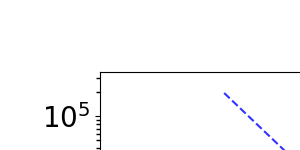

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 789
    # data points      = 10
    # variables        = 3
    chi-square         = 7397.28765
    reduced chi-square = 1056.75538
    Akaike info crit   = 72.0628359
    Bayesian info crit = 72.9705911
[[Variables]]
    q:  13541.6533 +/- 279.721985 (2.07%) (init = 1)
    w:  2.49451042 +/- 0.05949612 (2.39%) (init = 1)
    e:  1.65659059 +/- 0.17799929 (10.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(q, e) = -0.758
    C(q, w) =  0.356
[117, 89, 75, 60, 44, 38, 29, 22, 19, 15, 10, 9, 6, 4, 3]
параметры для синего
7144583629.824621 4.379433239570395
[[ 1.0635836  -0.23662496]
 [-0.23662496  0.05280468]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 2
    chi-square         = 2175.9

In [91]:
name_source = 'J0139+33'
file = '/home/oem/work/new_data/J0139+3310.txt'


step = 5
fitting_for_snr_and_number = 'yes'

#model = 'power-power' 
model = 'lognorm' 
model = 'lognorm-power' 
TREASHOLD = 10

date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[12, 22, 16, 14, 29, 19, 13, 32, 22, 17, 37, 26, 41, 39, 32, 29, 36, 26, 20, 24, 37, 41, 43, 41, 33, 38, 31, 35, 31, 34, 42, 18, 22, 28, 39, 45, 41, 53, 27, 33, 37, 14, 22, 25, 30, 35, 23, 34, 52, 39, 32, 39, 41, 31, 39, 30, 30, 31, 49, 48, 44, 41, 48, 42]
Медиана за сеанс (только если > 0):            1.7075782537067545
Медиана за сеанс (включаа дни без импульсов):  1.0


<IPython.core.display.Javascript object>


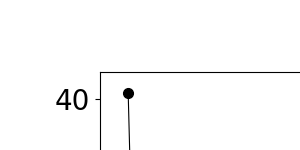

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


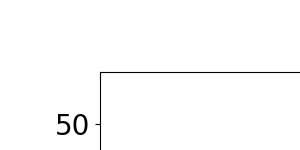

/home/oem/work/work/lib/python3.8/site-packages/lmfit/model.py:968: UserWarning:

The keyword argument x does not match any arguments of the model function. It will be ignored.

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [92]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number)

## J0302+22

10751
[10013   618    90    16     6     4     1     0     2]


<IPython.core.display.Javascript object>


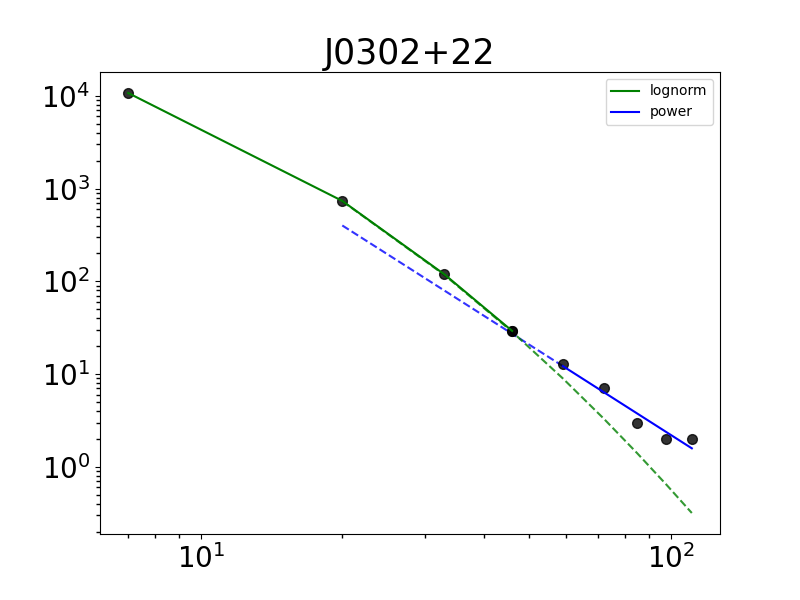

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 517
    # data points      = 4
    # variables        = 3
    chi-square         = 0.04630905
    reduced chi-square = 0.04630905
    Akaike info crit   = -11.8348491
    Bayesian info crit = -13.6759660
[[Variables]]
    q:  95293.0085 +/- 197.720553 (0.21%) (init = 1)
    w:  1.36632968 +/- 0.00343024 (0.25%) (init = 1)
    e:  0.84336089 +/- 0.00128959 (0.15%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(q, w) = -1.000
    C(w, e) = -0.998
    C(q, e) =  0.997
[13, 7, 3, 2, 2]
параметры для синего
6372094.881182174 3.2293825399239164
[[ 3.78363992 -0.85417994]
 [-0.85417994  0.19332903]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 5
    # variables        = 2
    chi-square         = 1.90014975
    reduced chi

In [145]:
name_source = 'J0302+22'
file = '/home/oem/work/new_data/J0302+22.txt'

step = 13
fitting_for_snr_and_number = 'yes'

#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 
model = 'lognorm-power' 


TREASHOLD = 4

date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[33, 134, 155, 193, 159, 145, 140, 130, 90, 100, 127, 140, 153, 106, 129, 81, 136, 165, 101, 115, 147, 166, 125, 163, 111, 132, 138, 126, 157, 180, 154, 196, 196, 194, 228, 202, 166, 267, 194, 203, 196, 249, 111, 136, 183, 231, 206, 159, 256, 222, 120, 206, 231, 217, 146, 164, 201, 214, 216, 174, 183, 219, 150, 202, 182]
Медиана за сеанс (только если > 0):            6.763224181360202
Медиана за сеанс (включаа дни без импульсов):  5.0


<IPython.core.display.Javascript object>


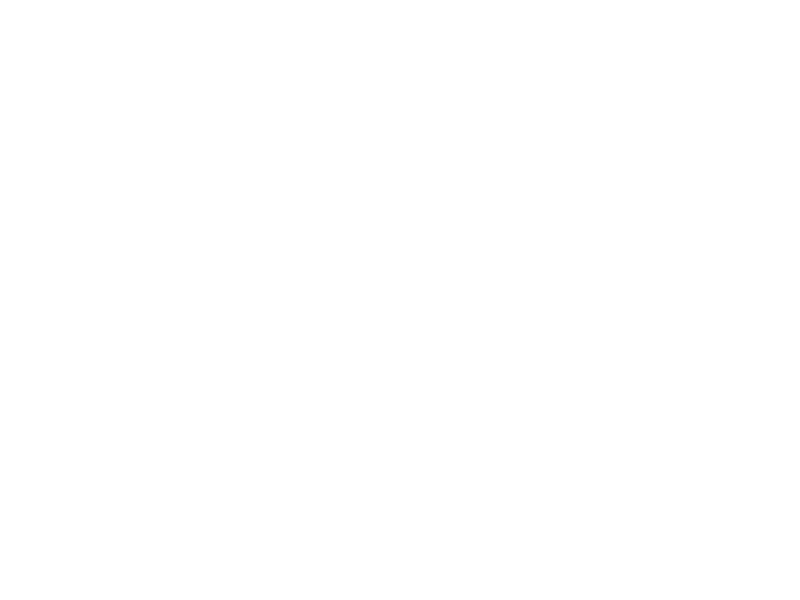

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


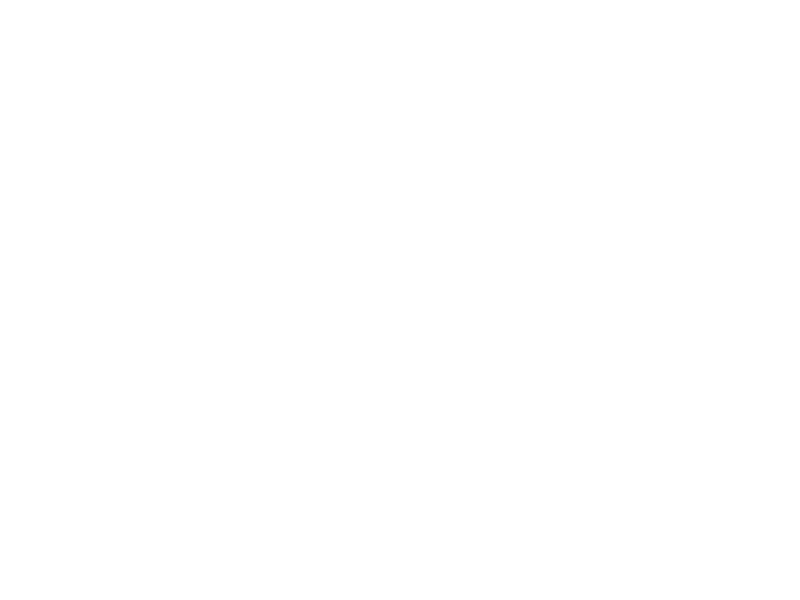

/home/oem/work/work/lib/python3.8/site-packages/lmfit/model.py:968: UserWarning:

The keyword argument x does not match any arguments of the model function. It will be ignored.

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [94]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'yes')

## J0317+13

1798
[416 447 288 209 130  93  71  43  34  15  12  10   4   4   4   5   1   3
   1   1   4   1   0   1   0   0]


<IPython.core.display.Javascript object>


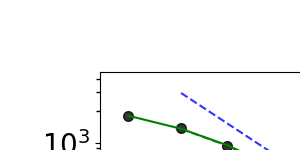

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 436
    # data points      = 5
    # variables        = 3
    chi-square         = 1122.93925
    reduced chi-square = 561.469624
    Akaike info crit   = 33.0713347
    Bayesian info crit = 31.8996485
[[Variables]]
    q:  10953.2869 +/- 258.759107 (2.36%) (init = 1)
    w:  1.72372842 +/- 0.04137980 (2.40%) (init = 1)
    e: -0.42086459 +/- 0.03251331 (7.73%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(w, e) =  0.962
    C(q, w) = -0.874
    C(q, e) = -0.761
[307, 214, 143, 100, 66, 51, 39, 29, 25, 21, 17, 12, 11, 8, 7, 6, 2]
параметры для синего
36910976.359908886 4.851169234472442
[[ 0.32868955 -0.1120178 ]
 [-0.1120178   0.03850722]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 17
    # variables        = 2


In [95]:
name_source = 'J0317+13'
file = '/home/oem/work/new_data/J0317+13.txt'



step = 1

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 5
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[46, 27, 13, 21, 12, 13, 16, 23, 14, 33, 18, 23, 25, 19, 16, 39, 36, 35, 50, 48, 50, 46, 63, 65, 56, 51, 52, 38, 24, 40, 44, 25, 40, 36, 40, 17, 19, 51, 55, 27, 46, 32, 43, 29, 41, 71, 66, 81, 23]
Медиана за сеанс (только если > 0):            2.1408114558472553
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


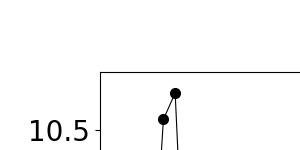

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


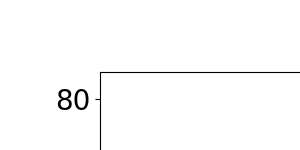

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [96]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J0609+16

[ 2 22 50 54 47 23 14  7  4 11  4  4  3  1  1  0  1  1  0]


<IPython.core.display.Javascript object>


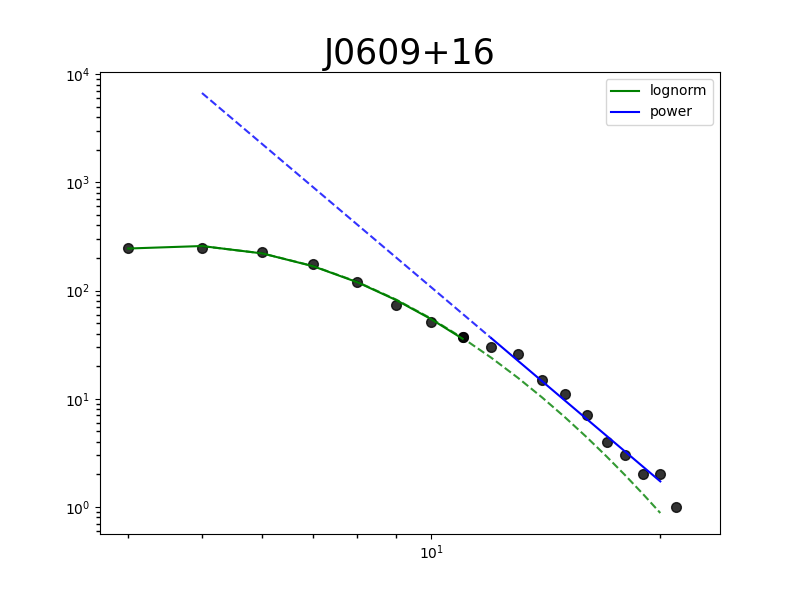

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 234
    # data points      = 8
    # variables        = 3
    chi-square         = 284.365501
    reduced chi-square = 56.8731001
    Akaike info crit   = 34.5665507
    Bayesian info crit = 34.8048754
[[Variables]]
    q:  1337.71277 +/- 28.8390042 (2.16%) (init = 1)
    w:  1.72622360 +/- 0.01195357 (0.69%) (init = 1)
    e:  0.42959891 +/- 0.01801710 (4.19%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(q, e) = -0.673
[30, 26, 15, 11, 7, 4, 3, 2, 2]
параметры для синего
98448173.35067621 5.962275064583956
[[ 0.67664952 -0.24436182]
 [-0.24436182  0.08856075]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 9
    # variables        = 2
    chi-square         = 54.1567468
    reduced chi-square = 7.73667811
    Akaik

In [5]:
name_source = 'J0609+16'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/J0609+16_ копия.txt'
file = '/home/oem/work/new_data/J0609+16.txt'

step = 1

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 8
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[4, 32, 2, 3, 4, 6, 24, 9, 4, 1, 1, 2, 2, 3, 1, 11, 8, 7, 5, 1, 1, 2, 2, 2, 2, 4, 7, 23, 9, 3, 3, 3, 7, 2, 1, 3, 14, 7, 8, 6, 2, 2, 1, 3, 2, 1]
Медиана за сеанс (только если > 0):            1.546583850931677
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


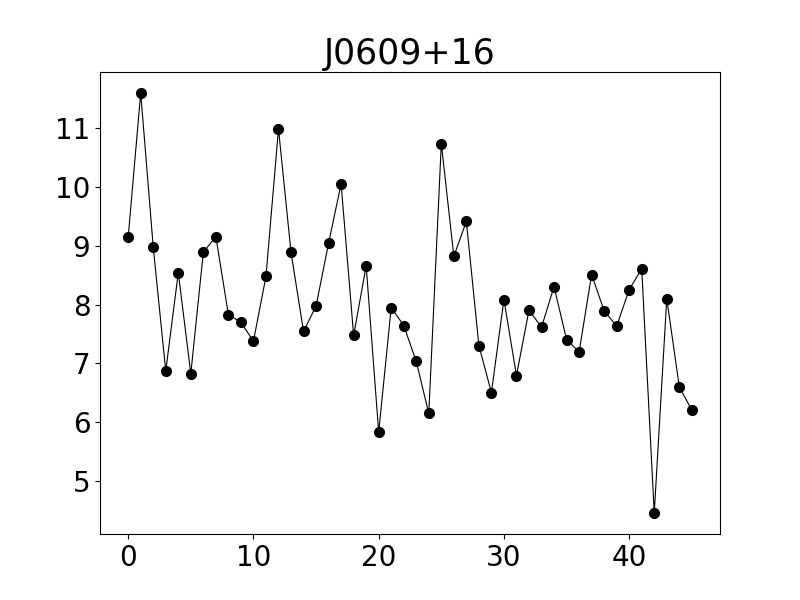

<ipython-input-4-d310116b0e70>:613: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


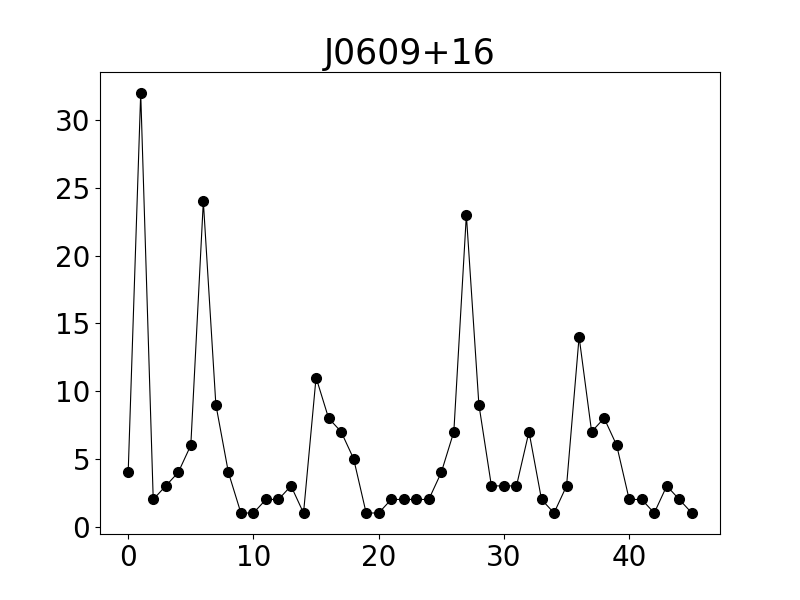

<ipython-input-4-d310116b0e70>:641: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [6]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J0640+07


In [3]:
name_source = 'J0640+07'
file = '/home/oem/work/new_data/J0640+07.txt'

step = 3
model = 'power' 
#model = 'power-power'
#model = 'lognorm'
#model = 'lognorm-power'

TREASHOLD = 4
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

90
[64  9  3  2  1  1  4  1  2  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


параметры для синего (линейн)
1837.2590370156843 1.8087576201502649
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 10
    # variables        = 2
    chi-square         = 423.793590
    reduced chi-square = 52.9741988
    Akaike info crit   = 41.4666143
    Bayesian info crit = 42.0717845
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  7.51603009 (init = 7.51603)
    b:  1.80875762 (init = 1.808758)
+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!
odict_items([('a', <Parameter 'a', value=7.516030086169878, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=1.8087576201502649, bounds=[-inf:inf]>)])
[71.8924672878327, 34.52844194934462, 20.52074340589445, 13.7058623378078, 9.855682023139298, 7.457549889442922, 5.857371791743039, 4.733477058795536, 3.9121551227977793, 3

[1, 2, 1, 2, 3, 3, 1, 2, 1, 3, 1, 3, 4, 3, 1, 2, 2, 1, 5, 6, 1, 3, 1, 1, 3, 1, 4, 2, 1, 1, 3, 1, 2, 1, 2, 3, 3, 2, 2, 1, 1, 1, 3]
Медиана за сеанс (только если > 0):            1.0595238095238095
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


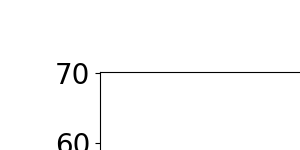

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


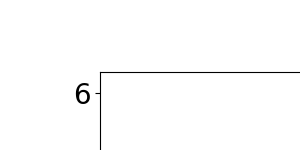

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [100]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J0659+14 

864
[387 246 112  44  26  13  13   8   3   0   4   1   2   0   0   1   0   0
   1   1   0]


<IPython.core.display.Javascript object>


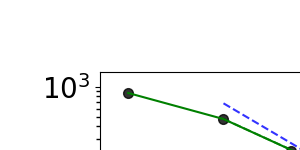

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 295
    # data points      = 4
    # variables        = 3
    chi-square         = 25.2743194
    reduced chi-square = 25.2743194
    Akaike info crit   = 13.3739779
    Bayesian info crit = 11.5328610
[[Variables]]
    q:  5182.83558 +/- 28.3820139 (0.55%) (init = 1)
    w:  1.82811304 +/- 0.01966026 (1.08%) (init = 1)
    e:  0.59045788 +/- 0.02028092 (3.43%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(w, e) = -0.925
[73, 47, 34, 21, 13, 10, 10, 6, 5, 3, 3, 3, 2, 2, 2]
параметры для синего
749330.2470348316 3.18812733663819
[[ 0.12843893 -0.03530126]
 [-0.03530126  0.00980095]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 15
    # variables        = 2
    chi-square         = 30.3890512
    reduced chi-square =

In [101]:
name_source = 'J0659+14'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'
file = '/home/oem/work/new_data/J0659+14.txt'


step = 3

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 4
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[2, 9, 11, 5, 7, 19, 28, 23, 8, 15, 31, 32, 34, 17, 10, 11, 15, 15, 12, 15, 15, 15, 18, 13, 10, 11, 9, 10, 4, 9, 8, 8, 6, 9, 16, 9, 12, 5, 10, 4, 10, 9, 7, 17, 9, 11, 22, 12, 21, 11, 6, 12, 11, 13, 6, 19, 17, 14, 26, 19, 20, 10, 12, 17, 13]
Медиана за сеанс (только если > 0):            1.4032520325203253
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


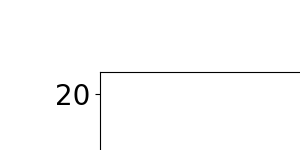

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


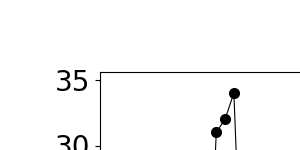

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [102]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1005+30 

In [51]:
name_source = 'J1005+30'
file = '/home/oem/work/new_data/J1005+30.txt'

step = 20

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 
#model = 'power_1005'

TREASHOLD = 5
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

389
[226  69  27  25  10  12   9   4   1   1   2   0   0   1   0   0   0   0
   0   1   0   0]


<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 387
    # data points      = 5
    # variables        = 3
    chi-square         = 28.6584028
    reduced chi-square = 14.3292014
    Akaike info crit   = 14.7300439
    Bayesian info crit = 13.5583576
[[Variables]]
    q:  4331.13651 +/- 85.2661770 (1.97%) (init = 1)
    w:  3.63336306 +/- 0.11917808 (3.28%) (init = 1)
    e:  1.65261528 +/- 0.10883949 (6.59%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(w, e) =  0.963
[31, 19, 10, 6, 5, 4, 2, 2, 2]
параметры для синего
81321532.93130212 3.180084669238976
[[ 0.96590781 -0.18571792]
 [-0.18571792  0.03582345]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 9
    # variables        = 2
    chi-square         = 8.63171233
    reduced chi-square = 1.23310176
    Akaike

[1, 6, 5, 9, 6, 9, 7, 7, 5, 1, 5, 2, 3, 6, 7, 6, 8, 3, 5, 9, 10, 8, 3, 3, 4, 6, 7, 3, 6, 13, 6, 8, 2, 4, 6, 5, 4, 8, 5, 9, 11, 3, 12, 5, 9, 7, 5, 7, 7, 6, 7, 9, 5, 6, 8, 6, 8, 4, 5, 7, 2, 4, 11, 5]
Медиана за сеанс (только если > 0):            1.063013698630137
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


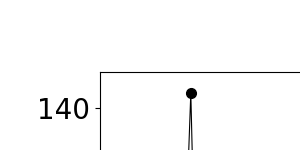

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


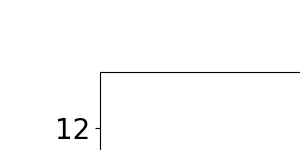

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [104]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1132+25 

206
[129  44  18   8   2   2   1   0   0]


<IPython.core.display.Javascript object>


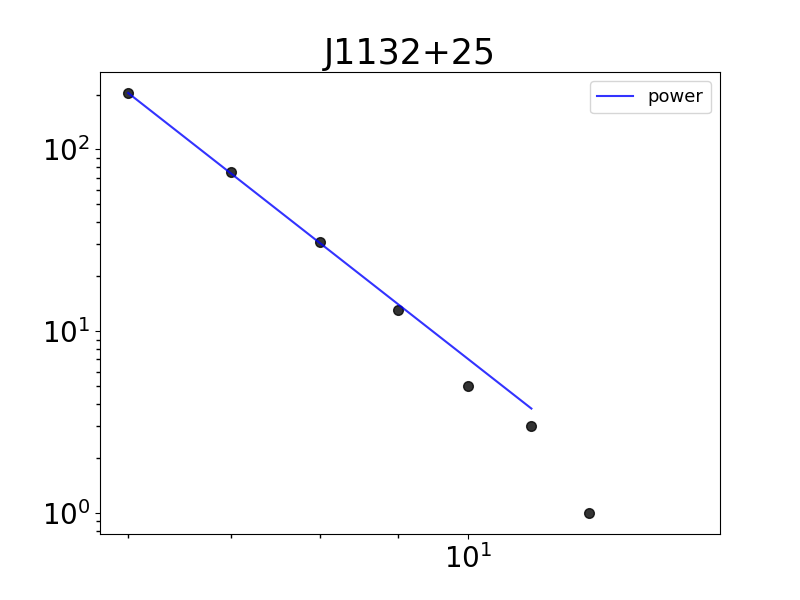

No handles with labels found to put in legend.


параметры для синего (линейн)
75422878.92832656 7.116825892090637
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 6
    # variables        = 2
    chi-square         = 224.673928
    reduced chi-square = 56.1684820
    Akaike info crit   = 25.7373440
    Bayesian info crit = 25.3208630
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  18.1386212 (init = 18.13862)
    b:  7.11682589 (init = 7.116826)
+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!
odict_items([('a', <Parameter 'a', value=18.138621221014066, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=7.116825892090637, bounds=[-inf:inf]>)])
[218.5426167853622, 72.96044817781628, 28.207779708865708, 12.199030218462768, 5.763379448397385, 2.924776469386024]
[-14.542616785362213, 2.039551822183725, 2.79222029113429

In [52]:
name_source = 'J1132+25'
file = '/home/oem/work/new_data/J1132+25.txt'

step = 1

#model = 'lognorm-power' 
model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 10
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[3, 5, 1, 6, 1, 3, 1, 7, 16, 9, 1, 3, 1, 5, 9, 2, 1, 1, 2, 3, 1, 2, 5, 25, 12, 3, 3, 7, 2, 1, 5, 1, 3, 16, 10, 7, 14, 9]
Медиана за сеанс (только если > 0):            1.4166666666666667
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


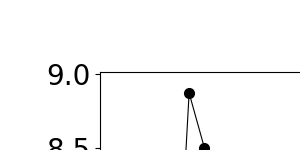

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


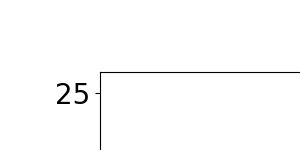

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [106]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1336+33 

157
[31 34 22 10 18  9  6  1  3  6  5  1  0  2  1  3  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0]


<IPython.core.display.Javascript object>


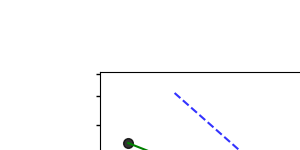

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 199
    # data points      = 7
    # variables        = 3
    chi-square         = 42.8993698
    reduced chi-square = 10.7248425
    Akaike info crit   = 18.6906289
    Bayesian info crit = 18.5283594
[[Variables]]
    q:  980.021745 +/- 61.4351505 (6.27%) (init = 1)
    w:  1.60757737 +/- 0.13649934 (8.49%) (init = 1)
    e:  0.64384828 +/- 0.09692918 (15.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(w, e) = -0.976
    C(q, w) = -0.955
    C(q, e) =  0.887
[26, 25, 22, 16, 11, 10, 10, 8, 7, 4, 4, 4, 3, 2]
параметры для синего
367383.1032802247 3.63611017732849
[[ 0.35945679 -0.12129044]
 [-0.12129044  0.04114082]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 14
    # variables        = 2
    chi-square      

In [107]:
name_source = 'J1336+33'
file = '/home/oem/work/new_data/J1336+33.txt'

step = 1

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 7
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[1, 1, 11, 4, 6, 12, 18, 11, 9, 6, 6, 9, 12, 7, 11, 2, 4, 6, 6, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1]
Медиана за сеанс (только если > 0):            1.2093023255813953
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


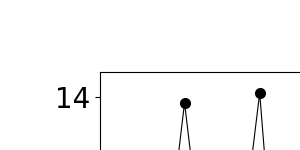

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


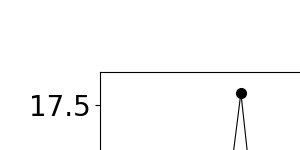

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [108]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1404+11

3492
[1577 1276  413  128   52   26    6    6    3    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


<IPython.core.display.Javascript object>


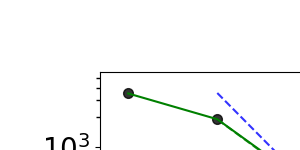

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 384
    # data points      = 4
    # variables        = 3
    chi-square         = 1039.60756
    reduced chi-square = 1039.60756
    Akaike info crit   = 28.2412168
    Bayesian info crit = 26.4000999
[[Variables]]
    q:  22052.3949 +/- 286.746482 (1.30%) (init = 1)
    w:  1.91825997 +/- 0.01130596 (0.59%) (init = 1)
    e:  0.39492287 +/- 0.01458710 (3.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(w, e) = -0.831
    C(q, e) = -0.788
    C(q, w) =  0.681
[97, 45, 19, 13, 7, 4]
параметры для синего
317663963.5259818 5.191832514473955
[[ 0.31398915 -0.0971796 ]
 [-0.0971796   0.03020112]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 6
    # variables        = 2
    chi-square         = 11.6283008
    reduced 

In [109]:
name_source = 'J1404+11'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'
file = '/home/oem/work/new_data/J1404+11.txt'

step = 3

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 4
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[169, 155, 142, 20, 62, 75, 37, 23, 30, 61, 56, 48, 22, 22, 19, 22, 18, 22, 6, 20, 40, 124, 153, 159, 310, 209, 269, 81, 77, 85, 88, 125, 67, 83, 74, 56, 28, 48, 26, 10, 13, 6, 14, 11, 20, 31, 10, 21, 25, 5, 26, 12, 11, 15, 11, 10, 71, 30, 9]
Медиана за сеанс (только если > 0):            4.049883990719257
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


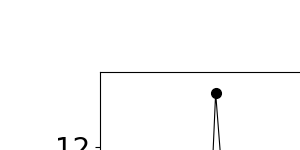

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


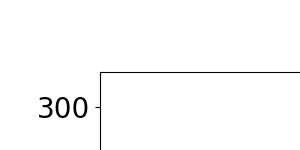

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [110]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1502+28 

4363
[1226  109   42   18    4    3    2    0    0    1    0    0    0]


<IPython.core.display.Javascript object>


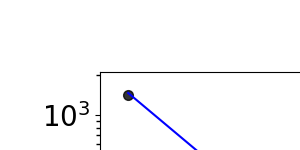

No handles with labels found to put in legend.


параметры для синего (линейн)
1707042.9484636884 3.6300975726285882
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 7
    # variables        = 2
    chi-square         = 3978.61446
    reduced chi-square = 795.722892
    Akaike info crit   = 48.3994513
    Bayesian info crit = 48.2912716
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  14.3502732 (init = 14.35027)
    b:  3.63009757 (init = 3.630098)
+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!
odict_items([('a', <Parameter 'a', value=14.350273161661406, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=3.6300975726285882, bounds=[-inf:inf]>)])
[1460.347139209706, 206.40072868615405, 58.29010064398281, 22.86225859880006, 10.870620188868942, 5.866825421755482, 3.463531772666872]
[-55.34713920970603, -27.4007286861

In [111]:
name_source = 'J1502+28'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'
file = '/home/oem/work/new_data/J1502+28.txt'


step = 5

#model = 'lognorm-power' 
model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 4
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[28, 86, 73, 85, 101, 94, 67, 85, 86, 57, 61, 81, 66, 83, 103, 64, 95, 83, 103, 73, 78, 77, 79, 56, 87, 62, 113, 67, 63, 80, 101, 93, 67, 96, 85, 56, 63, 93, 136, 73, 97, 115, 76, 104, 61, 129, 84, 63, 89, 122, 64, 49, 83, 28]
Медиана за сеанс (только если > 0):            5.060394889663183
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


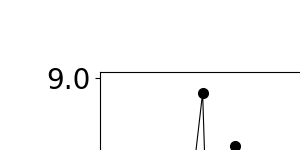

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


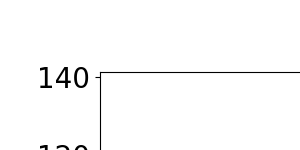

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [112]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1538+33 


2153
[1246  485  181  102   58   40   15    7    4    7    2    2    2    0
    0    0    1]


<IPython.core.display.Javascript object>


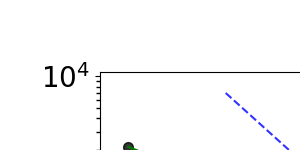

No handles with labels found to put in legend.


отчет по логнормальному
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 311
    # data points      = 6
    # variables        = 3
    chi-square         = 310.340434
    reduced chi-square = 103.446811
    Akaike info crit   = 29.6754624
    Bayesian info crit = 29.0507408
[[Variables]]
    q:  31630.3099 +/- 6036.85243 (19.09%) (init = 1)
    w:  0.76375328 +/- 0.24991687 (32.72%) (init = 1)
    e: -0.97072144 +/- 0.08148945 (8.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(q, w) = -0.998
    C(w, e) =  0.996
    C(q, e) = -0.988
[40, 25, 18, 14, 7, 5, 3, 1, 1, 1, 1]
параметры для синего
1649994960.2677722 5.375537974942319
[[ 1.9904209  -0.54147534]
 [-0.54147534  0.14797546]]
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 11
    # variables        = 2
    chi-square         = 141.

In [113]:
name_source = 'J1538+33'
file = '/home/oem/work/new_data/J1538+33.txt'

#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'

step = 3

model = 'lognorm-power' 
#model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 6
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[9, 20, 25, 81, 28, 18, 11, 69, 64, 27, 29, 58, 61, 28, 35, 13, 41, 57, 22, 27, 35, 28, 1, 13, 22, 34, 63, 27, 27, 59, 62, 71, 36, 22, 9, 3, 20, 33, 14, 17, 31, 8, 11, 39, 26, 37, 78, 64, 35, 17, 8, 13, 23, 4, 44, 21, 59, 38, 27, 41, 27, 36, 78, 69]
Медиана за сеанс (только если > 0):            2.2586750788643535
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


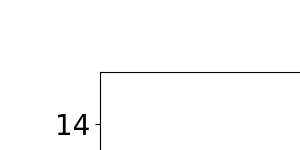

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


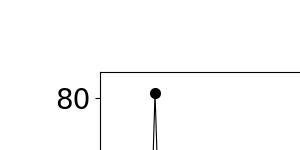

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [114]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J1848+15

307
[12 28 38 36 50 42 26 19 15 11  6  5  6  4  1  1  0  1  0  1  0  0  0  0
  0  0  0  0]


<IPython.core.display.Javascript object>


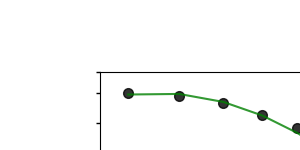

No handles with labels found to put in legend.


aic =  60.05
[[Model]]
    Model(lognorm)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 249
    # data points      = 18
    # variables        = 3
    chi-square         = 362.604604
    reduced chi-square = 24.1736403
    Akaike info crit   = 60.0529423
    Bayesian info crit = 62.7240575
[[Variables]]
    q:  2147.98089 +/- 21.8926097 (1.02%) (init = 1)
    w:  2.04390256 +/- 0.00727148 (0.36%) (init = 1)
    e:  0.40835336 +/- 0.00898741 (2.20%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(q, e) = -0.604
    C(w, e) = -0.539
    C(q, w) =  0.286
STD:  4.4836919563434146


In [115]:
name_source = 'J1848+15'
file = '/home/oem/work/new_data/J1848+15.txt'

#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'

step = 1

#model = 'lognorm-power' 
#model = 'power' 
model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 13
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[1, 7, 3, 4, 5, 4, 5, 4, 1, 4, 1, 2, 1, 5, 1, 1, 6, 7, 5, 11, 13, 9, 11, 9, 11, 5, 4, 12, 21, 19, 17, 29, 13, 7, 8, 11, 7, 7, 4, 3, 2, 2, 2, 1, 2]
Медиана за сеанс (только если > 0):            1.3076923076923077
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


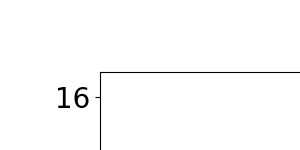

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


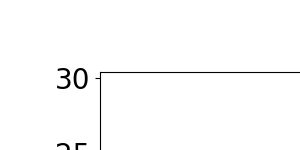

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [116]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J2051+12 

265
[249  12   2   0   1   0]


<IPython.core.display.Javascript object>


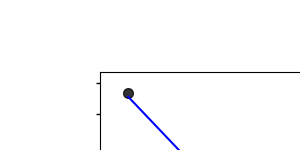

No handles with labels found to put in legend.


параметры для синего (линейн)
25905557.354497157 5.551242226321538
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 3
    # variables        = 2
    chi-square         = 166.249921
    reduced chi-square = 166.249921
    Akaike info crit   = 16.0446398
    Bayesian info crit = 14.2418643
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  17.0699681 (init = 17.06997)
    b:  5.55124223 (init = 5.551242)
+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!
odict_items([('a', <Parameter 'a', value=17.06996807332469, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=5.551242226321538, bounds=[-inf:inf]>)])
[251.2590252156443, 16.96772299194972, 2.786578003856112]
[12.7409747843557, -1.9677229919497208, 0.21342199614388813]
STD для синего:  6.48110726646828
отчет по степенному (

In [117]:
name_source = 'J2051+12'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'
file = '/home/oem/work/new_data/J2051+12.txt'

step = 5
#model = 'lognorm-power' 
model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 3
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[1, 1, 3, 6, 5, 3, 6, 7, 3, 1, 2, 1, 3, 2, 3, 2, 3, 16, 12, 11, 5, 3, 3, 1, 4, 6, 2, 10, 13, 15, 6, 9, 5, 7, 6, 2, 5, 3, 4, 4, 2, 4, 3, 3, 3, 2, 2, 1, 1, 2, 4, 5, 5, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4]
Медиана за сеанс (только если > 0):            1.1528384279475983
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


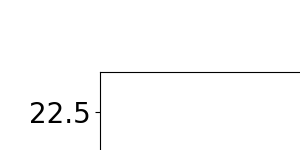

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


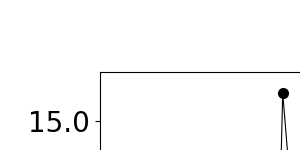

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [118]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J2105+19 

1327
[1057  188   55   12   10    2    1    1]


<IPython.core.display.Javascript object>


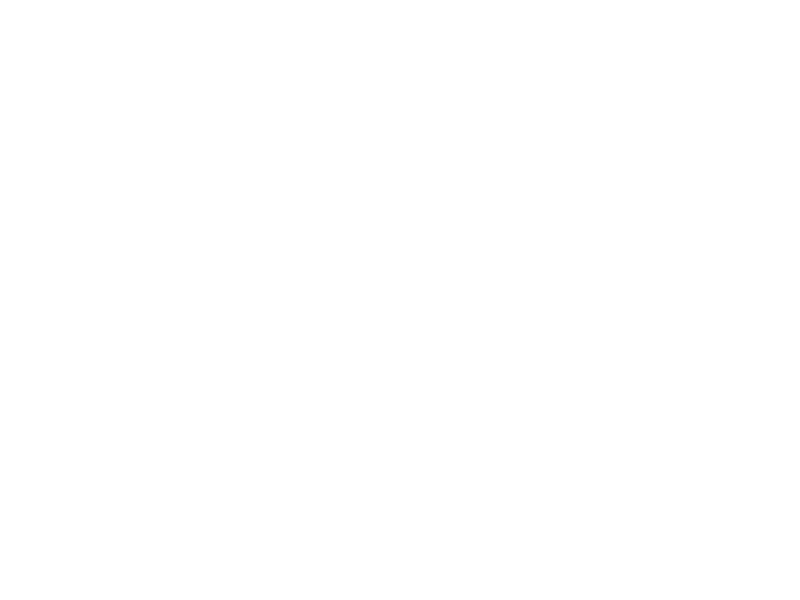

No handles with labels found to put in legend.


параметры для синего (линейн)
41007743.95857626 5.190122910424496
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 8
    # variables        = 2
    chi-square         = 129390.539
    reduced chi-square = 21565.0898
    Akaike info crit   = 81.5291920
    Bayesian info crit = 81.6880751
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  17.5292715 (init = 17.52927)
    b:  5.19012291 (init = 5.190123)
+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!
odict_items([('a', <Parameter 'a', value=17.529271483872005, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=5.190122910424496, bounds=[-inf:inf]>)])
[1685.400731959644, 264.6933111919138, 67.82080861825865, 23.08528116389494, 9.461881749813932, 4.421067707064289, 2.2771173421397632, 1.264555293069648]
[-359.40073195964396

In [119]:
name_source = 'J2105+19'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия.txt'
file = '/home/oem/work/new_data/J2105+19.txt'

step = 3

#model = 'lognorm-power' 
model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 4
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[18, 38, 12, 9, 38, 64, 51, 59, 18, 12, 5, 6, 7, 4, 5, 11, 7, 27, 21, 7, 15, 8, 6, 9, 11, 19, 15, 23, 14, 14, 30, 13, 13, 10, 3, 3, 2, 6, 6, 8, 5, 11, 8, 22, 13, 6, 7, 2, 6, 14, 21, 30, 88, 94, 51, 41, 74, 16, 17, 31, 25, 46, 30, 14, 8]
Медиана за сеанс (только если > 0):            2.3386243386243386
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


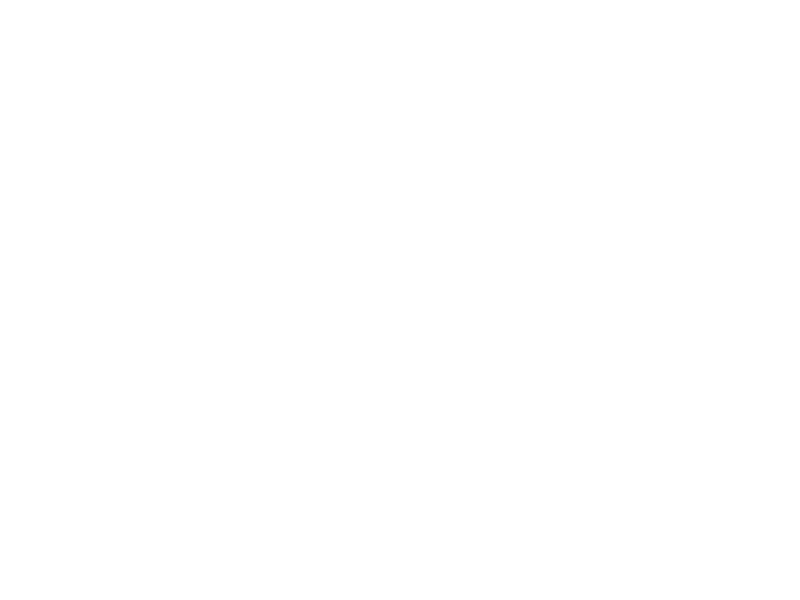

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


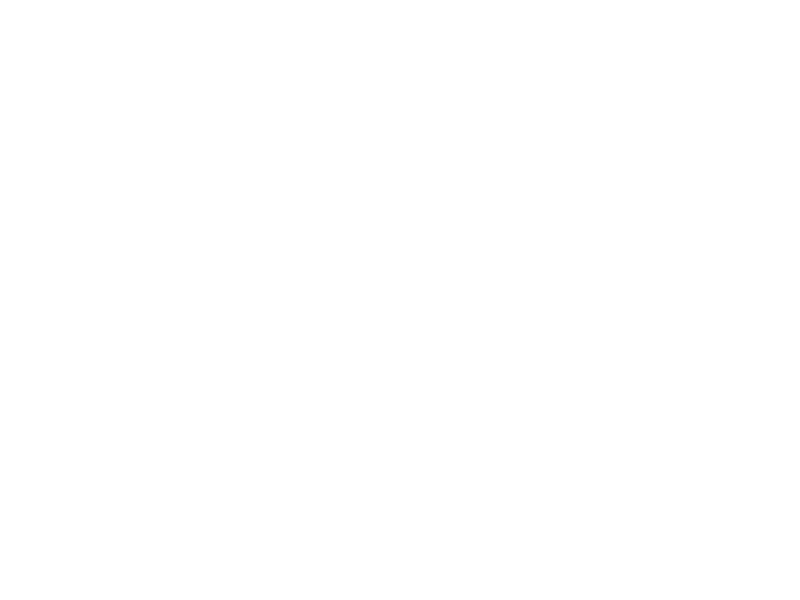

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [120]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## J2209+22 

260
[161  50  21   9   6   9   1   2]


<IPython.core.display.Javascript object>


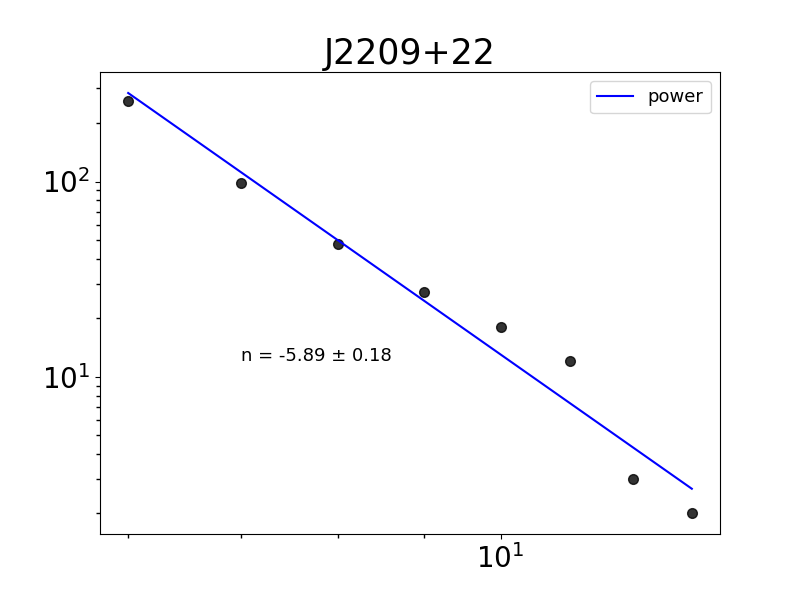

No handles with labels found to put in legend.


параметры для синего (линейн)
14254470.704284932 6.040346666752757
отчет по степенному (синему)
[[Model]]
    Model(custom_pow)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 8
    # variables        = 2
    chi-square         = 891.517432
    reduced chi-square = 148.586239
    Akaike info crit   = 41.7078676
    Bayesian info crit = 41.8667507
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  16.4725811 (init = 16.47258)
    b:  6.04034667 (init = 6.040347)
+++++++++++++++++++==================жопа==+++++++++++++++++++++++!!!!!!!!!!!!!!!
odict_items([('a', <Parameter 'a', value=16.47258114910886, bounds=[-inf:inf]>), ('b', <Parameter 'b', value=6.040346666752757, bounds=[-inf:inf]>)])
[284.2155165702429, 112.01236494122209, 50.000517937067585, 24.546836765641526, 12.989858761084712, 7.304294266166202, 4.318393896328291, 2.662852315565671]
[-25.215516570242

In [121]:
name_source = 'J2209+22'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/' + str(name_source) + '_копия(копия).txt'
#file = '/home/elinxt/Рабочий стол/Lena/New Data/J2209+22_середина 3 min.txt'
file = '/home/oem/work/new_data/J2209+22.txt'

#file = '/home/elinxt/Рабочий стол/Lena/New Data/J2209+22_копия (копия).txt'

step = 1

#model = 'lognorm-power' 
model = 'power' 
#model = 'lognorm' 
#model = 'power-power' 

TREASHOLD = 4
date, snr = file_reading (file)
int_hist, x_hist = integral_hist (snr, step, name_source)
distribution (model, name_source, TREASHOLD)

[2, 3, 1, 10, 39, 30, 14, 6, 2, 4, 2, 2, 1, 1, 3, 4, 2, 5, 4, 1, 2, 4, 1, 3, 1, 2, 6, 22, 6, 4, 2, 3, 3, 6, 9, 7, 8, 8, 4, 4, 5, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1]
Медиана за сеанс (только если > 0):            1.4076086956521738
Медиана за сеанс (включаа дни без импульсов):  0.0


<IPython.core.display.Javascript object>


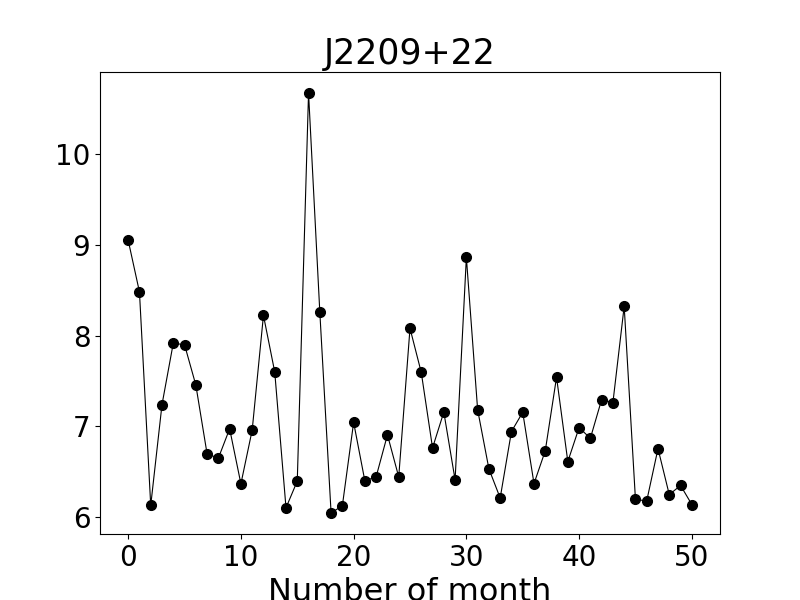

<ipython-input-90-75344475555c>:615: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



<IPython.core.display.Javascript object>


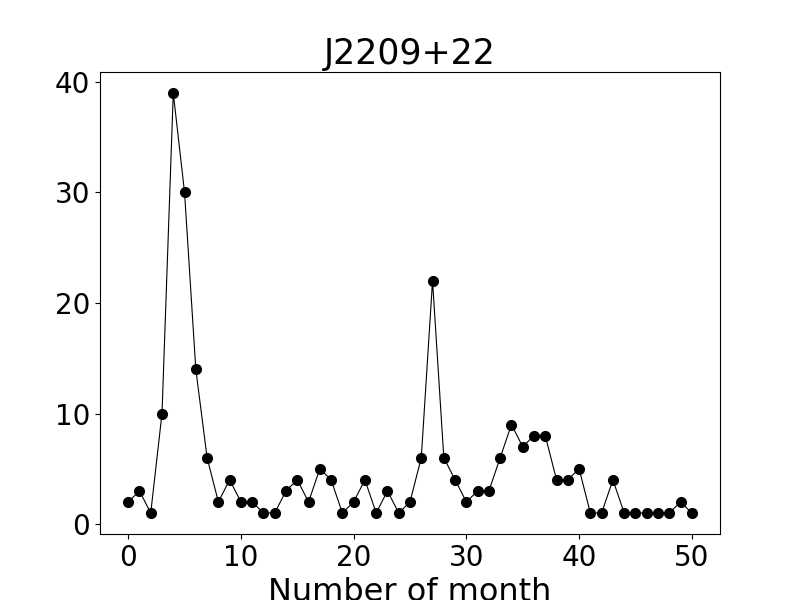

<ipython-input-90-75344475555c>:643: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later



In [122]:
snr_and_number_temp (name_source, date, snr, fitting_for_snr_and_number = 'no')

## number

In [130]:
from PIL import Image
import numpy as np
import os

num = glob.glob('/home/oem/work/rrat/num/J*.png')
num.sort()

images = [Image.open(x) for x in num]
def pil_grid(images, max_horiz=4):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    im_grid.save('/home/oem/work/rrat/num/all_num.png',format = 'png' ,  dpi = (10,10))
    return im_grid

In [131]:
im_grid = pil_grid(images, max_horiz=4)

##  snr

In [132]:
from PIL import Image
import numpy as np
import os
num = glob.glob('/home/oem/work/rrat/snr/J*.png')
num.sort()

images = [Image.open(x) for x in num]
def pil_grid(images, max_horiz=4):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    im_grid.save('/home/oem/work/rrat/snr/all_snr.png',format = 'png' ,  dpi = (10,10))
    return im_grid

In [133]:
im_grid = pil_grid(images, max_horiz=4)

##  distributions

In [127]:
from PIL import Image
import numpy as np
import os

num = glob.glob('/home/oem/work/rrat/distributions/J*.png')
num.sort()

images = [Image.open(x) for x in num]
def pil_grid(images, max_horiz=4):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    im_grid.save('/home/oem/work/rrat/distributions/all_dist.png',format = 'png' ,  dpi = (10,10))
    return im_grid

In [128]:
im_grid = pil_grid(images, max_horiz=4)

## extrapolation

## AICc

In [129]:
AIC = 1296.49533
#AIC = 42.0897003
k = 2
n = 15
AICc = AIC + (2*k**2 + 2*k)/(n-k-1)
print(AICc)

1297.49533


In [71]:
import powerlaw
from powerlaw import plot_pdf, Fit, pdf
data_y = int_hist[:-2]
data_x = x_hist[:-2]
fit = powerlaw.Fit(data_y)
print(data_y[:-2]);
print(data_x[:-2]);
print(fit.power_law.alpha)
print(fit.power_law.sigma)
fitt = [x**(-fit.power_law.alpha) for x in data_x]

[204, 75, 31, 13, 5]
[6, 7, 8, 9, 10]
1.5105982696439368
0.20845087069594379


Calculating best minimal value for power law fit


1.467113261436807
0.19069819043457598


Calculating best minimal value for power law fit


<IPython.core.display.Javascript object>


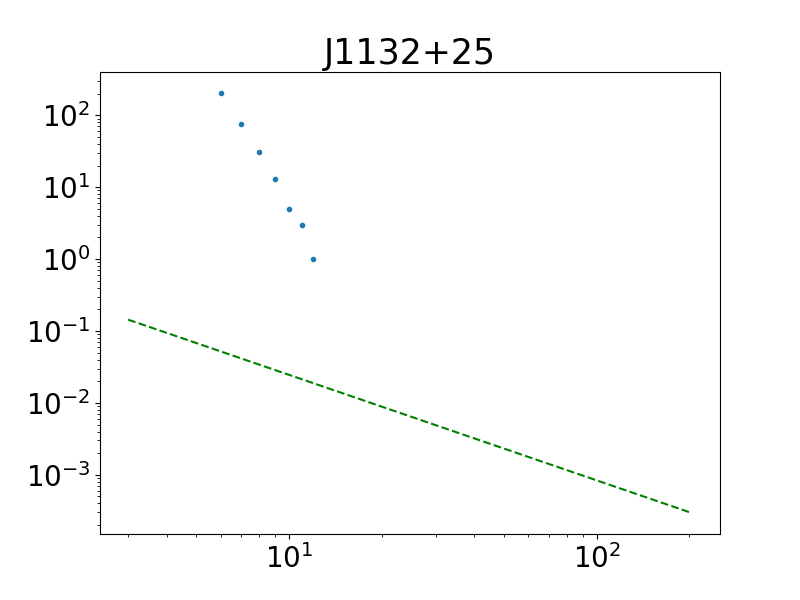

In [72]:

#fig2 = fit.plot_pdf(color='b', linewidth=2)
#fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
#fit.plot_pdf( color= 'b')


fit = powerlaw.Fit(data_y, discrete=True)
print(fit)
print(fit.power_law.alpha)
print(fit.power_law.sigma)
fitt = [fit.power_law.sigma*x**(-fit.power_law.alpha) for x in data_x]
fig, ax = plt.subplots(figsize=(8, 6))
fit.power_law.plot_pdf(linestyle='--', color='g')

plt.title(name_source, size = 25)
plt.plot(data_x,data_y,'.');
#plt.plot(data_x,fitt);

#plt.plot(data_x,fitt);ta_x
#ax.loglog()

<IPython.core.display.Javascript object>


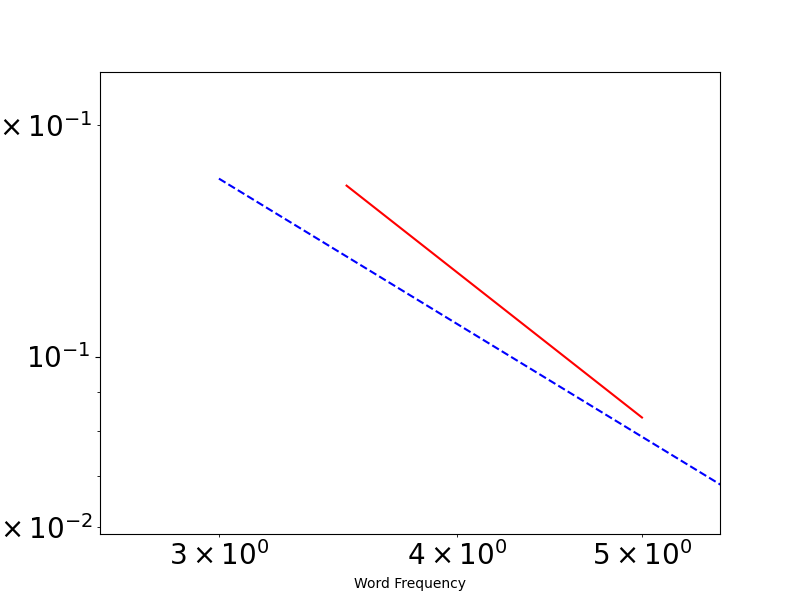

Calculating best minimal value for power law fit
/home/oem/work/work/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide

/home/oem/work/work/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide



<AxesSubplot:>

Text(0, 0.5, 'p(X),  p(X≥x)')

Text(0.5, 0, 'Word Frequency')

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))
data = data_y
fit = powerlaw.Fit(data)#, discrete=True, xmin = 6)
figCCDF = fit.plot_pdf(color='r')
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
####
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"Word Frequency")

figname = 'FigCCDF'

<IPython.core.display.Javascript object>


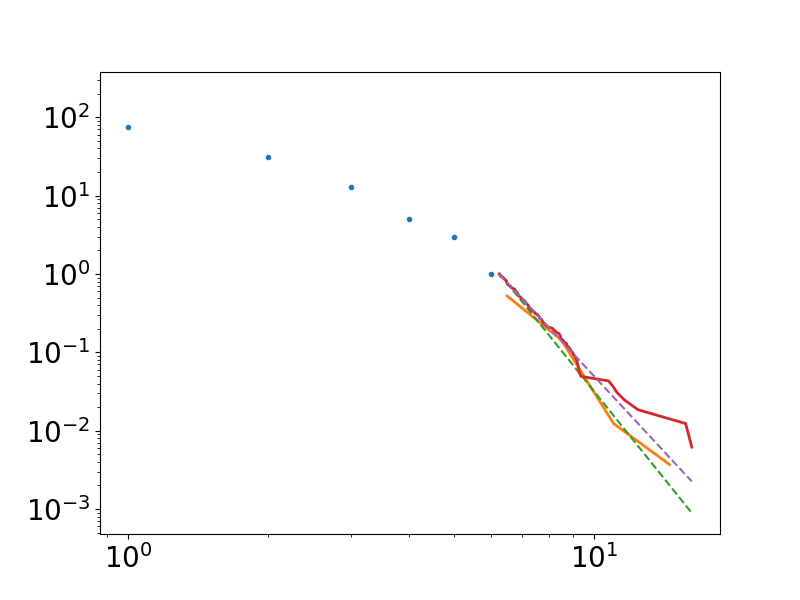

[]

In [93]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(data_y, '.')
ax.loglog()

<IPython.core.display.Javascript object>


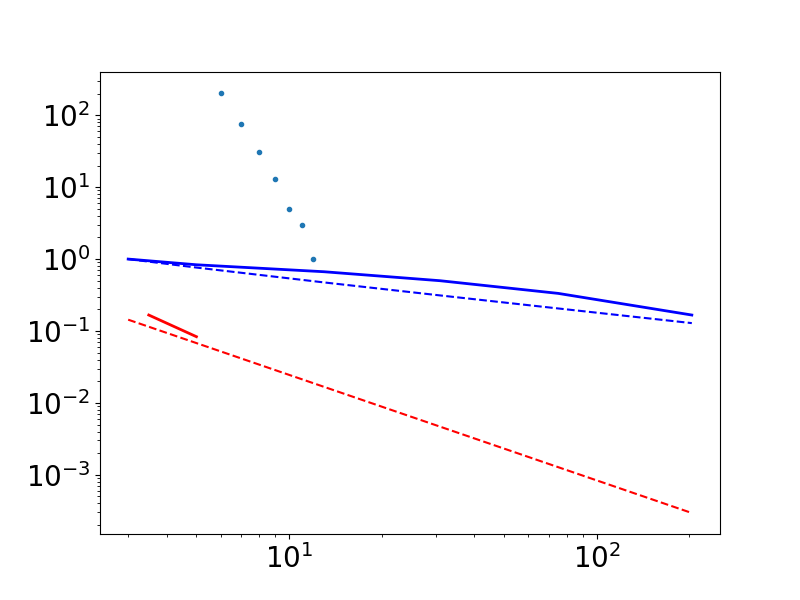

Calculating best minimal value for power law fit
/home/oem/work/work/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning:

invalid value encountered in true_divide



1.467113261436807

0.19069819043457598

(-0.5133795809646071, 0.5536446836738944)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

In [119]:
import powerlaw
data_y = int_hist[:-2]
data_x = x_hist[:-2]

In [101]:
print(snr)

[8.909, 6.322, 6.443, 10.729, 10.96, 7.831, 6.43, 6.245, 6.522, 6.145, 6.478, 6.864, 8.468, 8.126, 6.002, 8.874, 9.114, 7.148, 9.254, 6.58, 6.022, 6.036, 6.338, 9.363, 7.279, 8.458, 7.337, 6.214, 6.011, 6.816, 6.895, 8.998, 15.702, 7.065, 6.182, 6.928, 8.579, 6.131, 6.565, 6.253, 7.338, 6.065, 9.032, 6.688, 16.191, 7.873, 6.961, 8.313, 6.521, 6.635, 9.194, 6.381, 7.446, 9.114, 7.188, 6.39, 8.498, 6.005, 7.344, 7.638, 6.703, 8.72, 6.406, 6.027, 6.153, 7.065, 6.002, 6.277, 6.631, 6.628, 6.392, 6.673, 6.201, 6.042, 6.802, 7.919, 6.031, 6.295, 6.377, 6.471, 6.271, 7.515, 6.137, 6.113, 7.413, 6.61, 6.32, 7.757, 8.794, 6.408, 8.407, 7.241, 6.221, 6.105, 6.644, 6.279, 6.741, 6.955, 7.7, 7.625, 6.618, 8.437, 6.507, 6.467, 6.381, 6.121, 7.818, 6.898, 8.261, 12.414, 7.137, 8.165, 6.48, 6.083, 7.612, 9.29, 6.836, 6.755, 11.182, 6.269, 7.558, 7.719, 6.51, 7.557, 6.383, 6.051, 6.403, 6.505, 6.766, 6.005, 7.433, 7.293, 7.095, 6.607, 7.133, 8.724, 6.088, 6.01, 6.096, 7.206, 6.488, 7.018, 6.046, 6.479

<IPython.core.display.Javascript object>


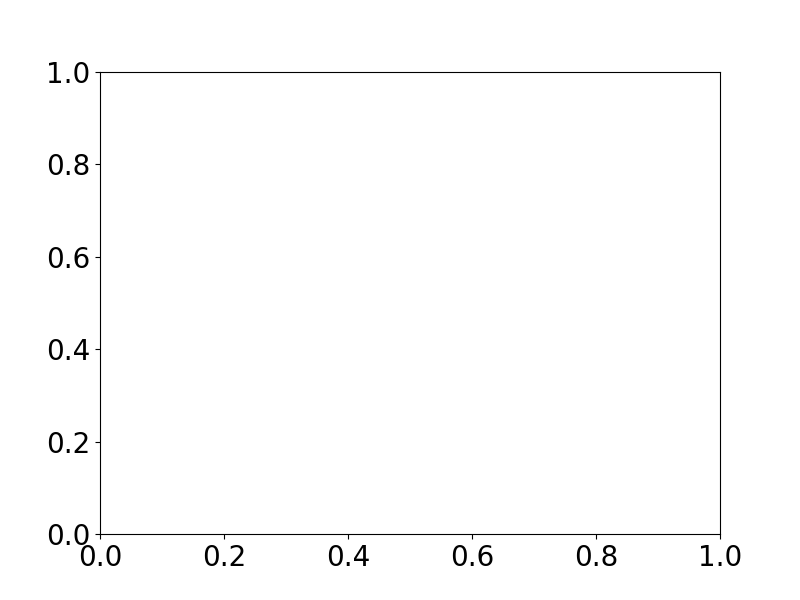

[ 6.  7. 10. 12. 17.] [0.52469136 0.14403292 0.01234568 0.0037037 ]


Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


(-0.014152369471843139, 0.006044541070098025)

In [147]:
import powerlaw
data_y = int_hist
data_x = x_hist
fig, ax = plt.subplots(figsize=(8, 6))
data = snr
fit = powerlaw.Fit(data)
x,y = fit.cdf()
bin_edges, probability = fit.pdf()
#y = fit.lognormal.cdf(data=[300, 350])
#y = fit.lognormal.pdf()
#plt.plot(y)
print(bin_edges, probability)
fit.distribution_compare('power_law','lognormal')

In [146]:
print(fit.power_law.parameter2)

None


In [148]:
print(data)

[8.909, 6.322, 6.443, 10.729, 10.96, 7.831, 6.43, 6.245, 6.522, 6.145, 6.478, 6.864, 8.468, 8.126, 6.002, 8.874, 9.114, 7.148, 9.254, 6.58, 6.022, 6.036, 6.338, 9.363, 7.279, 8.458, 7.337, 6.214, 6.011, 6.816, 6.895, 8.998, 15.702, 7.065, 6.182, 6.928, 8.579, 6.131, 6.565, 6.253, 7.338, 6.065, 9.032, 6.688, 16.191, 7.873, 6.961, 8.313, 6.521, 6.635, 9.194, 6.381, 7.446, 9.114, 7.188, 6.39, 8.498, 6.005, 7.344, 7.638, 6.703, 8.72, 6.406, 6.027, 6.153, 7.065, 6.002, 6.277, 6.631, 6.628, 6.392, 6.673, 6.201, 6.042, 6.802, 7.919, 6.031, 6.295, 6.377, 6.471, 6.271, 7.515, 6.137, 6.113, 7.413, 6.61, 6.32, 7.757, 8.794, 6.408, 8.407, 7.241, 6.221, 6.105, 6.644, 6.279, 6.741, 6.955, 7.7, 7.625, 6.618, 8.437, 6.507, 6.467, 6.381, 6.121, 7.818, 6.898, 8.261, 12.414, 7.137, 8.165, 6.48, 6.083, 7.612, 9.29, 6.836, 6.755, 11.182, 6.269, 7.558, 7.719, 6.51, 7.557, 6.383, 6.051, 6.403, 6.505, 6.766, 6.005, 7.433, 7.293, 7.095, 6.607, 7.133, 8.724, 6.088, 6.01, 6.096, 7.206, 6.488, 7.018, 6.046, 6.479